In [77]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cpi
cpi.update()
from datetime import date
from sqlalchemy import create_engine
import tensorflow as tf

In [125]:
# Read in data
tornado_data = pd.read_csv('Tornadoes_SPC_1950to2015.csv')
tornado_data.columns

Index(['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'fc'],
      dtype='object')

In [126]:
# Clean up file
tornado_data.rename(columns = {'yr':'Year', 'mo':'Month','dy':'Day','date':'Date','time':'Time','tz':'Time_Zone',
                               'st':'State','stf':'State_FIPS','stn':'State_No','mag':'Magnitude','inj':'Injuries',
                               'fat':'Fatalities','loss':'Property_Loss','closs':'Crop_Loss','slat':'Starting_Lat',
                               'slon':'Starting_Lon','elat':'Ending_Lat','elon':'Ending_Lon','len':'Length',
                               'wid':'Width'}, inplace = True)
tornado_data

om  Year  Month  Day        Date      Time  Time_Zone State  \
0           1  1950      1    3    1/3/1950  11:00:00          3    MO   
1           2  1950      1    3    1/3/1950  11:55:00          3    IL   
2           3  1950      1    3    1/3/1950  16:00:00          3    OH   
3           4  1950      1   13   1/13/1950   5:25:00          3    AR   
4           5  1950      1   25   1/25/1950  19:30:00          3    MO   
...       ...   ...    ...  ...         ...       ...        ...   ...   
60109  607506  2015     12   28  12/28/2015   3:20:00          3    LA   
60110  613277  2015     12   28  12/28/2015   4:46:00          3    AR   
60111  607307  2015     12   28  12/28/2015   5:43:00          3    MS   
60112  612738  2015     12   28  12/28/2015   8:30:00          3    FL   
60113  612739  2015     12   28  12/28/2015  15:58:00          3    NC   

       State_FIPS  State_No  ...  Fatalities  Property_Loss  Crop_Loss  \
0              29         1  ...           0           6.00        0.0   
1              17         2  ...           0           5.00        0.0   
2              39         1  ...           0           4.00        0.0   
3               5         1  ...           1           3.00        0.0   
4              29         2  ...           0           5.00        0.0   
...           ...       ...  ...         ...            ...        ...   
60109          22         0  ...           0           0.00        0.0   
60110           5         0  ...           0           0.05        0.0   
60111          28         0  ...           0           0.10        0.0   
60112          12         0  ...           0           0.01        0.0   
60113          37         0  ...           0           0.05        0.0   

       Starting_Lat  Starting_Lon  Ending_Lat  Ending_Lon  Length  Width  fc  
0             38.77        -90.22       38.83      -90.03    9.50    150   0  
1             39.10        -89.30       39.12      -89.23    3.60    130   0  
2             40.88        -84.58        0.00        0.00    0.10     10   0  
3             34.40        -94.37        0.00        0.00    0.60     17   0  
4             37.60        -90.68       37.63      -90.65    2.30    300   0  
...             ...           ...         ...         ...     ...    ...  ..  
60109         30.08        -90.54       30.08      -90.53    0.60    150   0  
60110         34.70        -90.92       34.78      -90.90    5.75     40   0  
60111         31.54        -89.53       31.61      -89.49    5.59    100   0  
60112         30.76        -87.24       30.77      -87.23    0.78     75   0  
60113         34.88        -80.53       34.89      -80.52    0.90     75   0  

[60114 rows x 22 columns]

In [127]:
# Remove zeroes from Property Loss column
# tornado_data = tornado_data[tornado_data['Property_Loss'] > 0]
# tornado_data

In [128]:
# Translate Property Loss to $ amounts - use midpoint in each range, translate to fraction of million
# 1 = .000025
# 2 = .000275
# 3 = .00275
# 4 = .0275
# 5 = .275
# 6 = 2.75
# 7 = 27.5
# 8 = 275
# 9 = 2750

tornado_data['Property_Loss'] = tornado_data['Property_Loss'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9], 
                                    [.000025, .000275, .00275, .0275, .275, 2.75, 27.5, 275, 2750])
tornado_data


om  Year  Month  Day        Date      Time  Time_Zone State  \
0           1  1950      1    3    1/3/1950  11:00:00          3    MO   
1           2  1950      1    3    1/3/1950  11:55:00          3    IL   
2           3  1950      1    3    1/3/1950  16:00:00          3    OH   
3           4  1950      1   13   1/13/1950   5:25:00          3    AR   
4           5  1950      1   25   1/25/1950  19:30:00          3    MO   
...       ...   ...    ...  ...         ...       ...        ...   ...   
60109  607506  2015     12   28  12/28/2015   3:20:00          3    LA   
60110  613277  2015     12   28  12/28/2015   4:46:00          3    AR   
60111  607307  2015     12   28  12/28/2015   5:43:00          3    MS   
60112  612738  2015     12   28  12/28/2015   8:30:00          3    FL   
60113  612739  2015     12   28  12/28/2015  15:58:00          3    NC   

       State_FIPS  State_No  ...  Fatalities  Property_Loss  Crop_Loss  \
0              29         1  ...           0        2.75000        0.0   
1              17         2  ...           0        0.27500        0.0   
2              39         1  ...           0        0.02750        0.0   
3               5         1  ...           1        0.00275        0.0   
4              29         2  ...           0        0.27500        0.0   
...           ...       ...  ...         ...            ...        ...   
60109          22         0  ...           0        0.00000        0.0   
60110           5         0  ...           0        0.05000        0.0   
60111          28         0  ...           0        0.10000        0.0   
60112          12         0  ...           0        0.01000        0.0   
60113          37         0  ...           0        0.05000        0.0   

       Starting_Lat  Starting_Lon  Ending_Lat  Ending_Lon  Length  Width  fc  
0             38.77        -90.22       38.83      -90.03    9.50    150   0  
1             39.10        -89.30       39.12      -89.23    3.60    130   0  
2             40.88        -84.58        0.00        0.00    0.10     10   0  
3             34.40        -94.37        0.00        0.00    0.60     17   0  
4             37.60        -90.68       37.63      -90.65    2.30    300   0  
...             ...           ...         ...         ...     ...    ...  ..  
60109         30.08        -90.54       30.08      -90.53    0.60    150   0  
60110         34.70        -90.92       34.78      -90.90    5.75     40   0  
60111         31.54        -89.53       31.61      -89.49    5.59    100   0  
60112         30.76        -87.24       30.77      -87.23    0.78     75   0  
60113         34.88        -80.53       34.89      -80.52    0.90     75   0  

[60114 rows x 22 columns]

In [129]:
# Adjust $ amount for inflation
tornado_data["Adj_Property_Loss"] = tornado_data.apply(lambda x: cpi.inflate(x["Property_Loss"], x["Year"]), axis=1)

tornado_data

om  Year  Month  Day        Date      Time  Time_Zone State  \
0           1  1950      1    3    1/3/1950  11:00:00          3    MO   
1           2  1950      1    3    1/3/1950  11:55:00          3    IL   
2           3  1950      1    3    1/3/1950  16:00:00          3    OH   
3           4  1950      1   13   1/13/1950   5:25:00          3    AR   
4           5  1950      1   25   1/25/1950  19:30:00          3    MO   
...       ...   ...    ...  ...         ...       ...        ...   ...   
60109  607506  2015     12   28  12/28/2015   3:20:00          3    LA   
60110  613277  2015     12   28  12/28/2015   4:46:00          3    AR   
60111  607307  2015     12   28  12/28/2015   5:43:00          3    MS   
60112  612738  2015     12   28  12/28/2015   8:30:00          3    FL   
60113  612739  2015     12   28  12/28/2015  15:58:00          3    NC   

       State_FIPS  State_No  ...  Property_Loss  Crop_Loss  Starting_Lat  \
0              29         1  ...        2.75000        0.0         38.77   
1              17         2  ...        0.27500        0.0         39.10   
2              39         1  ...        0.02750        0.0         40.88   
3               5         1  ...        0.00275        0.0         34.40   
4              29         2  ...        0.27500        0.0         37.60   
...           ...       ...  ...            ...        ...           ...   
60109          22         0  ...        0.00000        0.0         30.08   
60110           5         0  ...        0.05000        0.0         34.70   
60111          28         0  ...        0.10000        0.0         31.54   
60112          12         0  ...        0.01000        0.0         30.76   
60113          37         0  ...        0.05000        0.0         34.88   

       Starting_Lon  Ending_Lat  Ending_Lon  Length  Width  fc  \
0            -90.22       38.83      -90.03    9.50    150   0   
1            -89.30       39.12      -89.23    3.60    130   0   
2            -84.58        0.00        0.00    0.10     10   0   
3            -94.37        0.00        0.00    0.60     17   0   
4            -90.68       37.63      -90.65    2.30    300   0   
...             ...         ...         ...     ...    ...  ..   
60109        -90.54       30.08      -90.53    0.60    150   0   
60110        -90.92       34.78      -90.90    5.75     40   0   
60111        -89.53       31.61      -89.49    5.59    100   0   
60112        -87.24       30.77      -87.23    0.78     75   0   
60113        -80.53       34.89      -80.52    0.90     75   0   

       Adj_Property_Loss  
0              29.532376  
1               2.953238  
2               0.295324  
3               0.029532  
4               2.953238  
...                  ...  
60109           0.000000  
60110           0.054598  
60111           0.109195  
60112           0.010920  
60113           0.054598  

[60114 rows x 23 columns]

In [98]:
# create database
# from config import password
# connection_string = f"postgres:{password}@localhost:5432/tornado"
# # connection_string = f"postgres:postgres@localhost:5432/tornado"
# engine = create_engine(f'postgresql://{connection_string}')

In [99]:
# Put data into database
# tornado_data.to_sql(name='tornado_data', con=engine, if_exists='replace', index=False)

In [100]:
# pd.read_sql_query('select * from tornado_data', con=engine).head()

In [101]:
# Get X_train, X_test, y_train, y_test
# Scale data
# Run prediction model - neural network

In [130]:
# Split our preprocessed data into our features and target arrays
print(tornado_data["Property_Loss"].mean())
y = tornado_data['Property_Loss']
tornado_data = tornado_data.drop(columns=['Property_Loss', 'Date', 'Time', 'State', 'Year', 'Day','Time_Zone', 'om','State_No'])
tornado_data.head()

1.20291592016837


Month  State_FIPS  Magnitude  Injuries  Fatalities  Crop_Loss  \
0      1          29          3         3           0        0.0   
1      1          17          3         3           0        0.0   
2      1          39          1         1           0        0.0   
3      1           5          3         1           1        0.0   
4      1          29          2         5           0        0.0   

   Starting_Lat  Starting_Lon  Ending_Lat  Ending_Lon  Length  Width  fc  \
0         38.77        -90.22       38.83      -90.03     9.5    150   0   
1         39.10        -89.30       39.12      -89.23     3.6    130   0   
2         40.88        -84.58        0.00        0.00     0.1     10   0   
3         34.40        -94.37        0.00        0.00     0.6     17   0   
4         37.60        -90.68       37.63      -90.65     2.3    300   0   

   Adj_Property_Loss  
0          29.532376  
1           2.953238  
2           0.295324  
3           0.029532  
4           2.953238

In [139]:
# Convert categorical data to numeric with `pd.get_dummies`
tornado_data = pd.get_dummies(tornado_data, drop_first=True)
len(tornado_data.columns)


14

In [145]:
X_train, X_test, y_train, y_test = train_test_split(tornado_data, y, test_size=0.2)

In [152]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [153]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=200, activation="relu", input_dim=14))

# Second hidden layer
nn_model.add(tf.keras.layers.Dense(units=100, activation="relu"))

# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1))

# Check the structure of the model
nn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 200)               3000      
_________________________________________________________________
dense_28 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 101       
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________


In [154]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

# Fit the model to the training data
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=150)

Epoch 1/150
1503/1503 [==============================] - 4s 2ms/step - loss: 683.9153 - mae: 1.1998
Epoch 2/150
1503/1503 [==============================] - 3s 2ms/step - loss: 344.2783 - mae: 1.1292
Epoch 3/150
1503/1503 [==============================] - 3s 2ms/step - loss: 287.5519 - mae: 1.1208
Epoch 4/150
1503/1503 [==============================] - 3s 2ms/step - loss: 259.0981 - mae: 1.1198
Epoch 5/150
1503/1503 [==============================] - 3s 2ms/step - loss: 275.2140 - mae: 1.0276
Epoch 6/150
1503/1503 [==============================] - 3s 2ms/step - loss: 219.2200 - mae: 0.9608
Epoch 7/150
1503/1503 [==============================] - 3s 2ms/step - loss: 225.2191 - mae: 0.9230
Epoch 8/150
1503/1503 [==============================] - 3s 2ms/step - loss: 235.2618 - mae: 0.8746
Epoch 9/150
1503/1503 [==============================] - 3s 2ms/step - loss: 252.0725 - mae: 0.8649
Epoch 10/150
1503/1503 [==============================] - 3s 2ms/step - loss: 217.4677 - mae: 0.7754

1503/1503 [==============================] - 2s 2ms/step - loss: 172.6328 - mae: 0.4456
Epoch 82/150
1503/1503 [==============================] - 2s 2ms/step - loss: 168.4043 - mae: 0.4393
Epoch 83/150
1503/1503 [==============================] - 2s 2ms/step - loss: 118.5369 - mae: 0.4382
Epoch 84/150
1503/1503 [==============================] - 3s 2ms/step - loss: 132.6651 - mae: 0.4380
Epoch 85/150
1503/1503 [==============================] - 3s 2ms/step - loss: 117.4154 - mae: 0.4362
Epoch 86/150
1503/1503 [==============================] - 3s 2ms/step - loss: 119.1550 - mae: 0.4318
Epoch 87/150
1503/1503 [==============================] - 2s 2ms/step - loss: 99.4797 - mae: 0.4121
Epoch 88/150
1503/1503 [==============================] - 3s 2ms/step - loss: 135.6790 - mae: 0.4404
Epoch 89/150
1503/1503 [==============================] - 2s 2ms/step - loss: 75.0322 - mae: 0.4089
Epoch 90/150
1503/1503 [==============================] - 3s 2ms/step - loss: 93.7555 - mae: 0.4131
Epoch 

<AxesSubplot:>

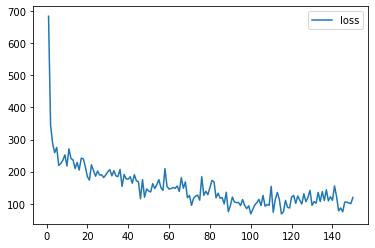

In [155]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")

<AxesSubplot:>

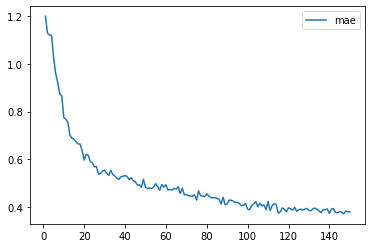

In [156]:
# Plot the accuracy
history_df.plot(y="mae")

In [157]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


376/376 - 0s - loss: 383.3101 - mae: 0.6591
Loss: 383.31011962890625, Accuracy: 0.6590926051139832
